In [1]:
from itertools import permutations
import random
from copy import deepcopy
import numpy as np
from scipy.stats import norm
import math
import statistics
from matplotlib import pyplot as plt
import pandas
import time

# Offline Evaluation

## Step 1: Simulate Ranking Pairs of E and P

In [2]:
def create_ranking_pairs():
    """
    Outputs a list of tuples with all possible ranking pairs from a pool of 12 document ids.
    The first list in each pair corresponds to system P, the second to system E.
    """
    list_of_pairs = []
    perm = list(permutations(range(12),3))
    for i in perm:
        for j in perm:
            pair = (list(i),list(j))
            list_of_pairs.append(pair)
    return list_of_pairs

def get_relevance(doc):
    """
    Outputs the integer relevance corresponding to a document id
    """
    if (doc<0 or doc>11):
        raise Exception('Document id should be from 0 to 12!')
    if doc<6:
        return 0
    else:
        return 1
    
def get_relevance_list(docs):
    """
    Maps a list of document ids to integer relevance
    """
    return [get_relevance(doc) for doc in docs]

## Step 2: Compute the $\Delta$ERR and form bins

In [3]:
def compute_click_probability(rel):
    """
    Outputs the click-probability theta.
    """
    rel_max = 1
    return (2**rel - 1)/2**rel_max

def compute_ERR(list):
    """
    Computes Expected Reciprocal Rank for a list of form [doc_id1, doc_id2, doc_id3].
    """
    ERR = 0
    for r in range(len(list)):
        theta_r = compute_click_probability(get_relevance(list[r]))
        prod = 1
        for i in range(r):
            prod *= (1-compute_click_probability(get_relevance(list[i])))
        ERR += prod*theta_r*1/(r+1)
    return ERR

def divide_pairs_over_bins(list_pairs):
    """
    Divides a list of pairs over 10 bins according to the delta ERR.
    The i'th element of dERRs contains all pairs with delta EER between i/10 and (i+1)/10
    Note that the first bin only starts at 0.05 to make sure it does not happen too often that P outperforms E
    """
    dERRs = [[] for i in range(10)]
    for i in list_pairs:
        deltaERR = compute_ERR(i[0]) - compute_ERR(i[1])
        #Keep all the positive delta ERRs and put them in the respective bin
        if deltaERR > 0.05:
            if deltaERR < 0.1:
                dERRs[0].append(i)
            else:
                bin = str(deltaERR*10)
                dERRs[int(bin[0])].append(i)
    return dERRs

# Online Evaluation
## Step 3: Implement Team-Draft and Probabilistic Interleaving

In [4]:
def coin_to_ranker(cointoss):
    """
    Maps zero to E (experimental system) and one to P (production system)
    """
    if (cointoss == 0):
        return "E"
    if (cointoss == 1):
        return "P"
    else:
        raise Exception('This number should be either 0 or 1!')
        
def softmax(r, max_r):
    """
    The softmax takes the rank of a document as well as the maximal rank and returns
    the probability of choosing that document
    """
    tau = 3
    ranks = range(1,max_r+1)
    normalizer = sum([rank**(-tau) for rank in ranks])
    return r**(-tau)/normalizer

def td_interleave(pair):
    """
    Performs team draft interleaving to a ranking pair
    Returns interleaved list as [(doc_id1, S1), (doc_id2, S2), (doc_id3, S3)] where
    Si describes which list contributed the document: E or P
    """
    new_pair = deepcopy(list([pair[0], pair[1]]))
    result = []
    for i in range(3):
        cointoss = random.randint(0, 1)
        result += [(new_pair[cointoss][0], coin_to_ranker(cointoss))]
        if (new_pair[cointoss][0] in new_pair[1 - cointoss]):
            new_pair[1 - cointoss].remove(new_pair[cointoss][0])
        new_pair[cointoss] = new_pair[cointoss][1:]
    return result

def pr_interleave(pair):
    """
    Performs probabilistic interleaving to a ranking pair
    Returns interleaved list as [(doc_id1, S1), (doc_id2, S2), (doc_id3, S3)] where
    Si describes which list contributed the document: E or P
    """
    new_pair = deepcopy(list([pair[0], pair[1]]))
    result = []
    sm = [[],[]]
    sm[0] = [softmax(r, 3) for r in range(1, 4)]
    sm[1] = [softmax(r, 3) for r in range(1, 4)]
    population = [[0, 1, 2], [0, 1, 2]]
    for i in range(3):
        cointoss = random.randint(0, 1)
        index = random.choices(population[cointoss], sm[cointoss])[0]
        sm[cointoss][index] = 0
        result += [(new_pair[cointoss][index], coin_to_ranker(cointoss))]
        for j in range(3):
            if (new_pair[cointoss][index] == new_pair[1 - cointoss][j]):
                sm[1 - cointoss][j] = 0       
    return result

def decide_winner(interl, clicks):
    """
    Takes an interleaved list and a click pattern and returns the winner: E, P or NW (no winner)
    """
    clicks_E = 0
    clicks_P = 0
    for i in range(3):
        if (clicks[i] == 1):
            if (interl[i][1] == "E"):
                clicks_E += 1
            elif (interl[i][1] == "P"):
                clicks_P += 1
    if (clicks_E > clicks_P):
        return "E"
    elif (clicks_E < clicks_P):
        return "P"
    else:
        return "NW"
    
def decide_winner_marg(interl, ranking_pair, clicks):
    """
    Returns winner of probabilistic interleaving according to the marginalised estimate
    Note that the probability of an assignment given an interleaved list is proportional
    to the probability of a list given an assignment, and thus only the latter is computed
    """
    prob_win = [0,0] # unnormalised 'probability' that system 0 or 1 wins
    
    # loop over assignments
    for assignment in [[a,b,c] 
                       for a in [0,1] 
                       for b in [0,1] 
                       for c in [0,1]]:
        prob_list = 1 # probability of interleaved list given assignment
        click_count = [0,0] # count how often each system's docs are clicked
        sm = [[softmax(r, 3) for r in range(1, 4)], 
              [softmax(r, 3) for r in range(1, 4)]]
        # loop over list positions
        for i in range(3):
            doc = interl[i][0]
            ass = assignment[i]
            cli = clicks[i]
            # count clicks
            click_count[ass] += cli
            # compute probability of list given assignment
            if doc not in ranking_pair[ass]:
                prob_list = 0
            else:
                index = ranking_pair[ass].index(doc)
                prob_list *= sm[ass][index]
                sm[ass][index] = 0
                sum_sm = sum(sm[ass])
                if sum_sm != 0:
                    sm[ass] = [s/sum_sm for s in sm[ass]]
        # assign win probability to appropriate system
        if click_count[0] != click_count[1]: # not a tie
            prob_win[click_count[1] > click_count[0]] += prob_list
    # return winner
    if (prob_win[1] > prob_win[0]):
        return "E"
    elif (prob_win[1] < prob_win[0]):
        return "P"
    else:
        return "NW"

## Step 4: Simulate User Clicks

In [5]:
def yandex_log_parser():
    """
    Parses the Yandex Click Log File and yields which ranks are clicked in a session.
    """
    sessionID = 0
    links = [-1 for i in range(10)] #dummy list
    clicks = [0 for i in range(10)]
    list_clicks = []
    with open("YandexRelPredChallenge.txt") as f:
        for line in f:
            words = line.split()
            sessionID_old = sessionID
            sessionID = int(words[0])
            if sessionID>sessionID_old:
                list_clicks.append(clicks)
                clicks = [0 for i in range(10)]
            recordType = words[2]
            if recordType=="Q":
                links = [int(l) for l in words[5:]]
            elif recordType=="C":
                link_clicked = int(words[3])
                if link_clicked in links:
                    rank_clicked = links.index(link_clicked)
                    clicks[rank_clicked] =1
    return(list_clicks)

def em():
    """
    Expectation-maximization method for determining the parameters alpha and gamma, using training data
    Using the update rules from: https://clickmodels.weebly.com/uploads/5/2/2/5/52257029/mc2015-clickmodels.pdf
    """
    diffs = [1]*11 # differences in parameters (first alpha, then ten gammas)
    diff_term = 1e-10 # minimal difference for termination
    max_iter = 100
    
    gamma = [0.5 for x in range(10)] # based on the book
    alpha = 0.2 #based on the book, initial probability clicked if not relevant
    epsilon = 0.05
    tolerance = 0.01
    click_log = yandex_log_parser()
    i = 0
    while i < max_iter and max(diffs) > diff_term:
        i+=1
        alpha_old = alpha
        gamma_old = gamma.copy()
        total = [2 for x in range(10)]
        for j in click_log:
            for rank in range(len(j)):
                gamma_value = gamma[rank]/total[rank]
                alpha_value = alpha/sum(total)
                if j[rank]==1:
                    gamma[rank] += 1
                    alpha += 1
                else:
                    alpha += (1-gamma_value)*alpha_value/(1-gamma_value*alpha_value)
                    gamma[rank] += (1-alpha_value)*gamma_value/(1-gamma_value*alpha_value)
                total[rank] += 1
        # New alpha and gamma
        alpha = alpha/sum(total)
        diffs[0] = abs(alpha-alpha_old)
        for x in range(len(gamma)):
            gamma[x] = gamma[x]/total[x]
            diffs[x+1] = abs(gamma[x]-gamma_old[x])
    return (alpha,gamma)

def click_probabilities(l, alpha, gamma):
    """
    Returns the probabilitof each position being clicked based on ranked relevance list l,
    and parameters alpha and gamma
    """
    return [abs(alpha - (1 - l[i]))*gamma[i] for i in range(3)]

def produce_clicks(list, alpha, gamma):
    """
    Performs the Position-Based Click Model (PBM)
    Returns which positions are clicked based on the ranked relevance list and parameters alpha and gamma
    """
    probabilities = click_probabilities(list, alpha, gamma)    
    return [np.random.binomial(1, probabilities[i]) for i in range(3)]

def produce_clicks_random(list, theta):
    """
    Performs the Random Click Model
    Returns which positions are clicked based on parameter theta (probability to click)
    """
    return [np.random.binomial(1, theta) for i in range(3)]

## Step 5: Simulate Interleaving Experiment

In [6]:
## Simulation of Interleaving Experiment


def estimate_win_proportion(ranking_pair, interleave_function, click_function, alpha, gamma, theta, k):
    """
    Runs experiment to estimate the win proportion of E on a single pair
    Interleaving and simulating clicks is done k times
    The ranking pair, functions to interleave and click and their parameters are arguments to this function
    Note that this function does not determine the winner by the marginalised estimation of probabilistic interleaving
    """
    wins_E = 0
    wins_P = 0
    for i in range(k):
        interl = interleave_function(ranking_pair)
        relevance_list = get_relevance_list([elem[0] for elem in interl])
        if (click_function == produce_clicks):
            clicks = click_function(relevance_list, alpha, gamma)
        elif (click_function == produce_clicks_random):
            clicks = click_function(relevance_list, theta)
        winner = decide_winner(interl, clicks)
        if (winner == "E"):
            wins_E += 1
        elif (winner == "P"):
            wins_P += 1
            
    if (wins_E + wins_P > 0):
        return wins_E / (wins_E + wins_P)
    else:
        return 0.5 # if all simulations resulted in a tie, return 0.5
    
    
# Determines win proportion of experimental system based on the marginalised estimator of probabilistic interleaving
def estimate_win_proportion_marginalised(ranking_pair, interleave_function, click_function, alpha, gamma, theta, k):
    """
    Runs experiment to estimate the win proportion of E on a single pair based on the marginalised estimation
    of probabilistic interleaving
    Interleaving and simulating clicks is done k times
    The ranking pair, functions to interleave and click and their parameters are arguments to this function
    """
    wins_E = 0
    wins_P = 0
    for i in range(k):
        # interleave 
        interl = interleave_function(ranking_pair)
        # simulate clicks
        relevance_list = get_relevance_list([elem[0] for elem in interl])
        if (click_function == produce_clicks):
            clicks = click_function(relevance_list, alpha, gamma)
        elif (click_function == produce_clicks_random):
            clicks = click_function(relevance_list, theta)
        # decide winning system
        winner = decide_winner_marg(interl, ranking_pair, clicks)
        if (winner == "E"):
            wins_E += 1
        elif (winner == "P"):
            wins_P += 1
            
    if (wins_E + wins_P > 0):
        return wins_E / (wins_E + wins_P)
    else:
        return 0.5 # if all simulations resulted in a tie, return 0.5
    
def run_interleaving_experiment(deltaERRs, estimator, interleaver, click_function, alpha, gamma, theta, k):
    """
    Runs a full interleaving experiment on ranking pairs orginised in bins (deltaERRs), using an estimator
    that runs the experiment for each pair based on an interleaver and click function
    Returns for each bin a tuple containing the minimum, maximum and median number of the estimated minimum 
    number of impressions N, and the percentage of pairs that resulted in a win probability of E lower than 0.5
    Note that in this case, N would be estimated as infinity
    """
    result = []
    counter = 0
    total_pairs = sum([len(d) for d in deltaERRs])
    print_at = np.ceil(np.linspace(total_pairs/5, total_pairs, 5))
    start_time = time.time()
        
    for i in range(len(deltaERRs)): # loop over bins
        if (len(deltaERRs[i])> 0):
            Ns = []
            count_Ninf = 0 # counts how often N is infinite (p1<=0.5)
            for pair in deltaERRs[i]: # loop over pairs in bin
                p1 = estimator(pair, interleaver, click_function, alpha, gamma, theta, k)
                counter += 1
                if counter in print_at:
                    print("\t{:.0f}%\t({:.0f} secs to go)".format(
                        counter/total_pairs*100,
                        math.ceil((time.time()-start_time)/counter*total_pairs-time.time()+start_time)))
                if (p1 > 0.5):
                    Ns += [compute_sample_size(p1)]
                else:
                    count_Ninf += 1
            if(len(Ns) > 0):
                minimum = min(Ns)
                maximum = max(Ns)
                median = statistics.median(Ns)
                result += [(minimum, median, maximum, count_Ninf/len(deltaERRs[i][100:]))]
            else:
                result += [(None,None,None, 1)]
        else:
            result += [(None,None,None, None)]
    return result

## Step 6: Compute Sample Size

In [7]:
def compute_sample_size(p1):
    """
    Returns the required minimal sample size according to the power analysis of the 
    one-sided one-sample proportion test with alpha 0.05, beta 0.1 and p0 0.5
    """
    a = 0.05
    b = 0.1
    p0 = 0.5
    delta = abs(p1-p0)
    N_intermediate = ((norm.ppf(1 - a)*math.sqrt(p0*(1-p0)) + 
                      norm.ppf(1 - b)*math.sqrt(p1*(1 - p1)))
                      /delta)**2
    N = N_intermediate + 1/delta
    return math.ceil(N)

## Tables and Plots

In [16]:
def results_table(results):
    """
    Shows a table of min, median and max number of impressions in each bin, and the
    percentage of experiments per bin that led to infinite N
    """
    xlabels = ["min", "median", "max", "infinite"]
    ylabels = []
    table = []
    i = 0
    for row in results:
        ylabels.append("{:.2f} - {:.2f}".format(.05 if i==0 else i/10, (i+1)/10))
        i += 1
        if row[0] is None:
            table.append(["-"]*4)
        else:
            table.append(["{:.0f}".format(row[0]),
                          "{:.1f}".format(row[1]),
                          "{:.0f}".format(row[2]),
                          "{:.1f}%".format(row[3]*100)])
            
    return pandas.DataFrame(table, ylabels, xlabels)


def plot_medians(td_pb, td_rn, pr_pb, pr_rn):
    """
    Displays plot of median number of impressions per interleaving method and click model
    """
    data_dict = {
        "team draft, PBM": td_pb,
        "team draft, rand": td_rn,
        "probab, PBM": pr_pb,
        "probab, rand": pr_rn}
    
    for name in data_dict.keys():
        medians = [row[1] for row in data_dict[name]]
        plt.plot([x+1 for x in range(10)],medians, "o-", label=name)

    plt.legend()
    plt.ylabel("median")
    plt.xlabel("bin")
    plt.title("Median impressions per bin")
    plt.show()

# Experiment execution

Creating all ranking pairs
	1742400 pairs created

Computing deltaERR for each pair and assigning pairs to bins
	7 non-empty bins created

Performing EM to estimate position based click model parameters
	alpha: 0.950 (manually set after EM)
	gammas: 0.998, 0.781, 0.619

Setting random click model parameter
	theta: 0.500

Starting online experiments with k=50

Running experiment 1: team draft interleaving & position-based click model
	20%	(972 secs to go)
	40%	(740 secs to go)
	60%	(498 secs to go)
	80%	(250 secs to go)
	100%	(0 secs to go)

Running experiment 2: team draft interleaving & random click model
	20%	(837 secs to go)
	40%	(630 secs to go)
	60%	(418 secs to go)
	80%	(209 secs to go)
	100%	(0 secs to go)

Running experiment 3: probabilistic interleaving & position-based click model
	20%	(4551 secs to go)
	40%	(3297 secs to go)
	60%	(2174 secs to go)
	80%	(1081 secs to go)
	100%	(0 secs to go)

Running experiment 4: probabilistic interleaving & random click model
	20%	(4282 sec

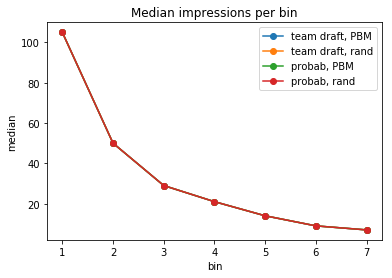

In [15]:
print("Creating all ranking pairs")
pairs = create_ranking_pairs() #list of all distinct ranking pairs
print("\t{} pairs created\n".format(len(pairs)))

print("Computing deltaERR for each pair and assigning pairs to bins")
deltaERRs = divide_pairs_over_bins(pairs) #list of all pairs (tuples of two lists) divided over the 10 bins
print("\t{} non-empty bins created\n".format(len([bin for bin in deltaERRs if len(bin) > 0])))

print("Performing EM to estimate position based click model parameters")
(alpha, gamma) = em()
epsilon = 0.05
alpha = 1 - epsilon    # alpha is manually determined
gamma = gamma[:3]      # only first 3 gammas are used
print("\talpha: {:.3f} (manually set after EM)".format(alpha))
print("\tgammas: {}\n".format(", ".join(["{:.3f}".format(g) for g in gamma])))

print("Setting random click model parameter")
theta = 0.5
print("\ttheta: {:.3f}\n".format(theta))

k = 50
print("Starting online experiments with k={}".format(k))

# Experiment 1: team draft interleaving, position-based click model
estimator = estimate_win_proportion
interleaver = td_interleave
clicker = produce_clicks
print("\nRunning experiment 1: team draft interleaving & position-based click model")
results_td_pb = run_interleaving_experiment(deltaERRs, 
                                    estimator, 
                                    interleaver, 
                                    clicker, 
                                    alpha, gamma, theta, k)

# Experiment 2: team draft interleaving, random click model
estimator = estimate_win_proportion
interleaver = td_interleave
clicker = produce_clicks_random
print("\nRunning experiment 2: team draft interleaving & random click model")
results_td_rn = run_interleaving_experiment(deltaERRs, 
                                    estimator, 
                                    interleaver, 
                                    clicker, 
                                    alpha, gamma, theta, k)

# Experiment 3: probabilistic interleaving, position-based click model
estimator = estimate_win_proportion_marginalised
interleaver = pr_interleave
clicker = produce_clicks
print("\nRunning experiment 3: probabilistic interleaving & position-based click model")
results_pr_pb = run_interleaving_experiment(deltaERRs, 
                                    estimator, 
                                    interleaver, 
                                    clicker, 
                                    alpha, gamma, theta, k)

# Experiment 4: probabilistic interleaving, random click model
estimator = estimate_win_proportion_marginalised
interleaver = pr_interleave
clicker = produce_clicks_random
print("\nRunning experiment 4: probabilistic interleaving & random click model")
results_pr_rn = run_interleaving_experiment(deltaERRs, 
                                    estimator, 
                                    interleaver, 
                                    clicker, 
                                    alpha, gamma, theta, k)

print("Showing results\n\n")

print("Experiment 1: team draft interleaving & position-based click model")
print(results_table(results_td_pb))

print("Experiment 2: team draft interleaving & random click model")
print(results_table(results_td_rn))
    
print("Experiment 3: probabilistic interleaving & position-based click model")
print(results_table(results_pr_pb))

print("Experiment 4: probabilistic interleaving & random cl ick model")
print(results_table(results_pr_rn))

print("\nPlotting median impressions per bin")
plot_medians(results_td_pb, results_td_rn, results_pr_pb, results_pr_rn)


Plotting median impressions per bin


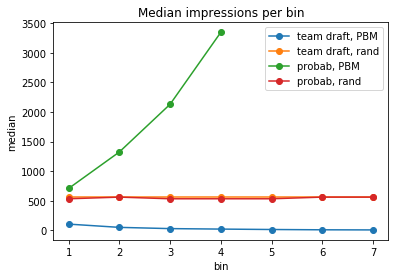

In [17]:
print("\nPlotting median impressions per bin")
plot_medians(results_td_pb, results_td_rn, results_pr_pb, results_pr_rn)